<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [906]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
from Functions.binary_dm import transform_binary_to_depthmap
from scipy.stats import uniform, randint
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

# Tiefenkarte lesen und plotten

Einlesen der Binary

In [907]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\(FinaleTiefenkarte)\Teller\Gurke_Apfel\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)

Einlesen des RGB image

In [908]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\(FinaleTiefenkarte)\Teller\Gurke_Apfel\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [909]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

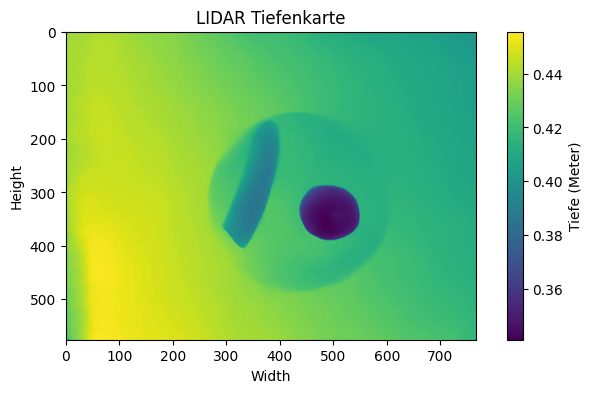

In [910]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


# Rescaling

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [911]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

In [912]:
dm_height, dm_width= depth_map.shape
print(f"height:{dm_height} , width:{dm_width}")

height:576 , width:768


Skalierung des RGB-Bilds, um die Segmentierung korrekt auf die Tiefenkarte anzuwenden

In [913]:
# Bild auf 576x768 skalieren
rgb_im = rgb_im.resize((768, 576), Image.BILINEAR)  # BILINEAR für weiche Skalierung

In [914]:
rgb_im.size

(768, 576)

# Segmentierung

## R-CNN laden

In [915]:
# Mask R-CNN Modell mit COCO-Gewichten laden
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [916]:
# Bild laden
image = rgb_im
image_tensor = F.to_tensor(image).unsqueeze(0)

# Bild durch das Modell laufen lassen
with torch.no_grad():
    prediction = model(image_tensor)

## Best label

In [917]:
best_index = None
best_score = 0.0
best_label = None

# Iteriere durch alle erkannten Objekte
for i, label in enumerate(prediction[0]['labels']):
    score = prediction[0]['scores'][i].item()
    
    print(f"Objekt {i}: COCO-Klasse {label}, Score: {score:.2f}")

    # Falls dieser Score der höchste ist, speichere das Label
    if score > best_score:
        best_score = score
        best_label = label
        best_index = i  # Speichert auch den Index des besten Objekts

# Ausgabe des besten Labels
if best_label is not None:
    print(f"\nBestes Label: COCO-Klasse {best_label}, Score: {best_score:.2f}")
else:
    print("\nKeine gültige Vorhersage gefunden.")


Objekt 0: COCO-Klasse 53, Score: 0.99
Objekt 1: COCO-Klasse 51, Score: 0.79
Objekt 2: COCO-Klasse 67, Score: 0.72
Objekt 3: COCO-Klasse 49, Score: 0.25
Objekt 4: COCO-Klasse 52, Score: 0.22
Objekt 5: COCO-Klasse 47, Score: 0.18
Objekt 6: COCO-Klasse 53, Score: 0.17
Objekt 7: COCO-Klasse 42, Score: 0.05
Objekt 8: COCO-Klasse 58, Score: 0.05

Bestes Label: COCO-Klasse 53, Score: 0.99


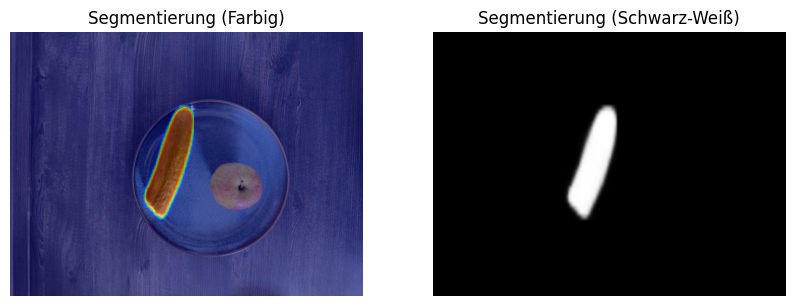

In [1022]:

# **Erste Plot: Originalbild mit Overlay (Farbig)**
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Erste Hälfte des Plots
plt.imshow(image)

for i, mask in enumerate(prediction[0]['masks']):
    if prediction[0]['labels'][i] == 58: # 51 scheinbar bowl #47 scheinabr teller
        mask_np = mask.squeeze().cpu().numpy()
        plt.imshow(mask_np, alpha=0.5, cmap="jet")  # Farbliche Überlagerung

plt.axis("off")
plt.title("Segmentierung (Farbig)")

# **Zweiter Plot: Nur die Maske in Schwarz-Weiß**
plt.subplot(1, 2, 2)  # Zweite Hälfte des Plots
plt.imshow(mask_np, cmap="gray")
plt.axis("off")
plt.title("Segmentierung (Schwarz-Weiß)")

plt.show()


## Smallest mask

Maskenauswahl anhand von kleinster Fläche

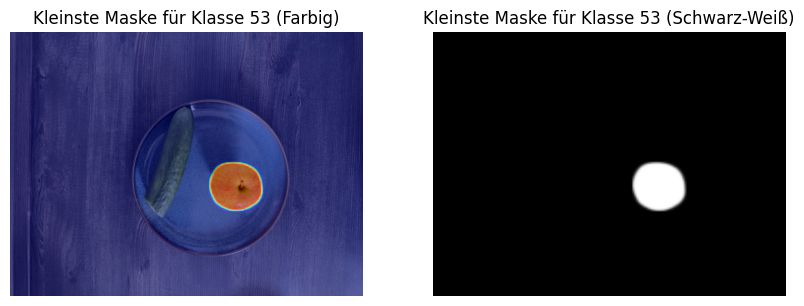

In [1015]:
smallest_mask = None
smallest_size = float('inf')  # Startwert: Unendlich groß

for i, mask in enumerate(prediction[0]['masks']):
    if prediction[0]['labels'][i] == best_label:  # Nur für die gewählte Klasse
        mask_np = mask.squeeze().cpu().numpy()
        mask_size = np.sum(mask_np)  # Anzahl der aktivierten Pixel berechnen

        if mask_size < smallest_size and mask_size > 0:  # Kein leeres Objekt
            smallest_size = mask_size
            smallest_mask = mask_np

if smallest_mask is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(smallest_mask, alpha=0.5, cmap="jet")
    plt.axis("off")
    plt.title(f"Kleinste Maske für Klasse {best_label} (Farbig)")

    plt.subplot(1, 2, 2)
    plt.imshow(smallest_mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Kleinste Maske für Klasse {best_label} (Schwarz-Weiß)")

    plt.show()
else:
    print(f"Keine gültige Maske für Klasse {best_label} gefunden.")


## Duale Masken

In [1025]:
combined_mask = mask_np  +  smallest_mask

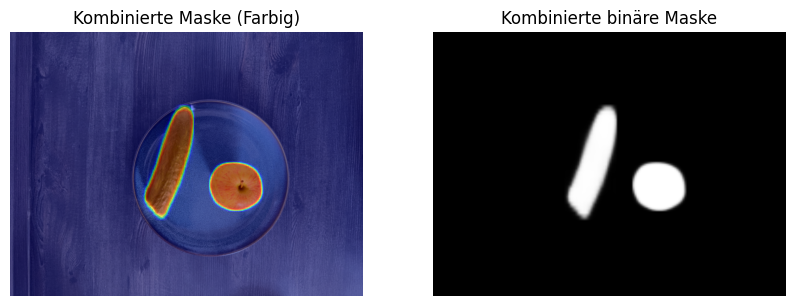

In [1024]:
plt.figure(figsize=(10, 5))

# Originalbild mit überlagerter Maske
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.imshow(combined_mask, alpha=0.5, cmap="jet")  # Transparente Überlagerung
plt.axis("off")
plt.title("Kombinierte Maske (Farbig)")

# Graustufenmaske anzeigen
plt.subplot(1, 2, 2)
plt.imshow(combined_mask, cmap="gray")
plt.axis("off")
plt.title("Kombinierte binäre Maske")

plt.show()



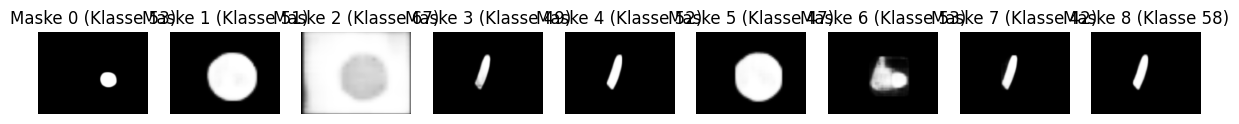

In [925]:
fig, axes = plt.subplots(1, len(prediction[0]['masks']), figsize=(15, 5))

for i, mask in enumerate(prediction[0]['masks']):
    mask_np = mask.squeeze().cpu().numpy()
    axes[i].imshow(mask_np, cmap="gray")
    axes[i].set_title(f"Maske {i} (Klasse {prediction[0]['labels'][i].item()})")
    axes[i].axis("off")

plt.show()


## Maske anwenden

In [1039]:
import numpy as np
import torch

def split_depth_map(depth_map, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy()  # In NumPy-Array umwandeln, falls Tensor

    depth_object = depth_map * mask  # Tiefenwerte innerhalb der Maske
    depth_background = depth_map * (1 - mask)  # Tiefenwerte außerhalb der Maske

    return depth_object, depth_background


# Tiefenkarten berechnen
depth_object, depth_background = split_depth_map(depth_map, smallest_mask)
depth_objects_dual, depth_background_dual = split_depth_map(depth_map, combined_mask)

# Optional: Werte ausgeben
print("Durchschnittliche Tiefe (Objekt):", np.mean(depth_object[depth_object > 0]))
print("Durchschnittliche Tiefe (Hintergrund):", np.mean(depth_background[depth_background > 0]))


Durchschnittliche Tiefe (Objekt): 0.25667906
Durchschnittliche Tiefe (Hintergrund): 0.41841033


Filterung von Ausreißern am Rand der Segmentierung

In [1044]:
mask_np = (smallest_mask > 0.5).astype(np.uint8)  # Binärmaske erstellen
dual_np = (combined_mask > 0.5).astype(np.uint8)
depth_object = depth_map * mask_np  # Nur Werte in der Maske beibehalten
dual_objects  = depth_map * dual_np

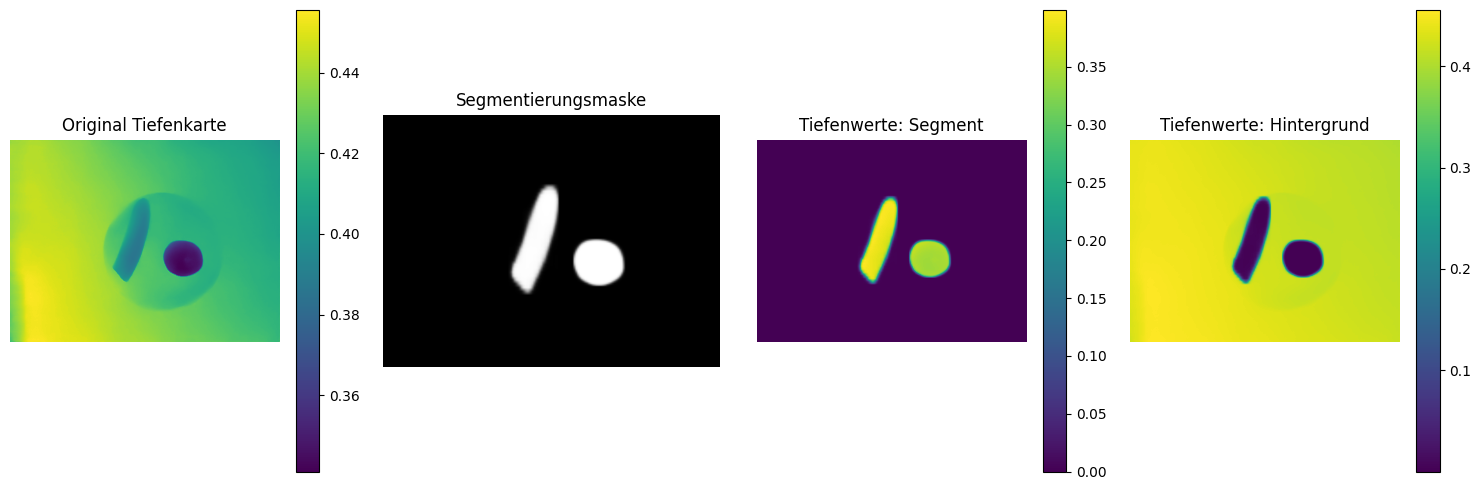

In [1027]:
import matplotlib.pyplot as plt

def visualize_depth_maps(depth_map, depth_object, depth_background, mask):
    plt.figure(figsize=(15, 5))
    
    # Binäre Maske
    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Segmentierungsmaske")
    
    # Original Tiefenkarte
    plt.subplot(1, 4, 1)
    plt.imshow(depth_map, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Original Tiefenkarte")
    
    # Tiefenkarte für das Objekt (Foreground)
    plt.subplot(1, 4, 3)
    plt.imshow(depth_object, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Segment")
    
    # Tiefenkarte für den Hintergrund (Background)
    plt.subplot(1, 4, 4)
    plt.imshow(depth_background, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Hintergrund")
    
    plt.tight_layout()
    plt.show()

# Visualisierung aufrufen
visualize_depth_maps(depth_map, depth_object, depth_background, mask_np)


# Intrinsic camera calibration

intrinsische Matrix

In [1028]:
intrinsic_matrix = np.array([
    [2876.100341796875, 0, 2018.2723388671875],
    [0, 2876.100341796875, 1518.2470703125],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.87610034e+03 0.00000000e+00 2.01827234e+03]
 [0.00000000e+00 2.87610034e+03 1.51824707e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [1029]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [1030]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [1031]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[547.82863653   0.         384.43282645]
 [  0.         547.82863653 289.18991815]
 [  0.           0.           1.        ]]


scaled intrinsic

In [1032]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 547.8286365327381, fy: 547.8286365327381, cx: 384.43282645089283, cy: 289.18991815476187


# Create point cloud

## Ganze Punktwolke

Open3D Object without metric scaling

In [1033]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [1034]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [1035]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=2.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutzt bei Stride = 1
)


In [1036]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


In [1037]:
# o3d.visualization.draw_geometries([pcd])

In [1038]:
pcd_array = np.asarray(pcd.points, dtype=np.float16)

## Maskierte Punktwolke

In [ ]:
# Open3D Image erstellen (Nullwerte bleiben, werden aber gefiltert)
depth_image = o3d.geometry.Image(depth_object.astype(np.float32))

# Punktwolke aus der Tiefenkarte erstellen (nur segmentierte Punkte)
pcd_object = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # Falls Tiefendaten in Metern vorliegen
    depth_trunc=3.0,  # Maximal erlaubte Tiefe (ggf. anpassen)
    stride=1
)

In [1046]:
pcd_object_array = np.asarray(pcd_object.points, dtype=np.float16)

In [1047]:
# Visualisierung (Nur segmentierte Punkte)
o3d.visualization.draw_geometries([pcd_object])

## Estimating normals

In [1048]:
nn_distance = np.mean(pcd_object.compute_nearest_neighbor_distance())

print(nn_distance)

0.0007794512154155613


In [1049]:
radius_normals = nn_distance * 4

pcd_object.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd_object.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 22759 points.

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [1050]:
pcd_center = pcd_object.get_center()
pcd_object.translate(pcd_center)

PointCloud with 22759 points.

# Punktwolke ausfüllen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

Wir benötigen die untersten Punkte der Objekt-Punktwolke

In [1051]:
min_z_object = min(pcd_object_array[:, 2].tolist()) 
print(f"Tiefster z-Wert des Objekts: {min_z_object}")

Tiefster z-Wert des Objekts: 0.341064453125


In [1052]:
# Maximalen z-Wert des Objekts bestimmen
max_z_object = max(pcd_object_array[:, 2].tolist()) 
print(f"Tiefster z-Wert des Objekts: {max_z_object}")

Tiefster z-Wert des Objekts: 0.433837890625


In [1053]:
# Durchschnitt
avg_z_plane = pcd_object_array[:, 2].mean()
print(f"Durchschnittliche Tiefe der Ebene: {avg_z_plane}")

Durchschnittliche Tiefe der Ebene: 0.37841796875


In [1054]:
# Minimalen z-Wert der Ebene bestimmen
max_z_plane = pcd_object_array[:, 2].max()
print(f"Tiefster z-Wert der Ebene: {max_z_plane}")

Tiefster z-Wert der Ebene: 0.433837890625


This code extends all the points of the object and thus creates a dense object. 

In [1055]:
# Punkte in Z-Richtung erweitern
new_points_dos = []
for x, y, z in pcd_object_array:
    # Falls der Punkt zu tief liegt, berechne eine Korrektur
    
    current_z = z
    while current_z < max_z_object:
        current_z += 0.0015
        if current_z > max_z_object:
            break
        new_points_dos.append([x, y, current_z])


# Neue Punkte zur Open3D Punktwolke hinzufügen
new_points_dos = np.array(new_points_dos)  # Am Ende in ein numpy-Array umwandeln

# Punktwolke der neuen Punkte visualisieren

pcd_object_comp = o3d.geometry.PointCloud()
pcd_object_comp.points = o3d.utility.Vector3dVector(new_points_dos)

#o3d.visualization.draw_geometries([pcd_object_comp])

In [1056]:
o3d.visualization.draw_geometries([pcd_object_comp])

# Clean Point Cloud

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

Beste Parameter ermitteln

In [1057]:
# Parameter-Suchbereich definieren
random_params_sor = {
    "nb_neighbors": randint(50, 200),  # Werte zwischen 50 und 200
    "std_ratio": uniform(0.8, 2.0)    # Werte zwischen 0.8 und 2.8
}

# Evaluierungsfunktion für SOR
def evaluate_sor(nb_neighbors, std_ratio, pointcloud):
    pcd_copy = pointcloud  # Kopie der Punktwolke, um Originaldaten zu erhalten
    cl, ind = pcd_copy.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return len(ind)  # Maximierung der Anzahl der verbleibenden Punkte


# Randomized Search
n_trials = 30  # Anzahl der getesteten Parameterkombinationen
best_score_plane = 0
best_params_plane = None

Beste Parameter für Object

In [1058]:
best_score_object = 0
best_params_object = None

for _ in range(n_trials):
    params = {key: dist.rvs() for key, dist in random_params_sor.items()}
    score = evaluate_sor(**params, pointcloud=pcd_object_comp)  # SOR für Object

    if score > best_score_object:
        best_score_object = score
        best_params_object = params

print("Beste Parameter SOR Object:", best_params_object)

Beste Parameter SOR Object: {'nb_neighbors': 99, 'std_ratio': np.float64(2.7859756426400732)}


Function to visualize clean pointcloud and the removed outliers

In [1059]:
# Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html
# Verbesserte Laufzeit der vorherigen Funktion

def display_outliers_fast(cloud, ind):
    """ Visualisiert die entfernten Punkte (Outlier) und die verbleibenden Punkte (Inlier) schneller mit NumPy. """
    
    if len(ind) == 0:
        print("Keine Outlier gefunden!")
        return

    points = np.asarray(cloud.points)  # Punktwolke als NumPy-Array
    outlier_mask = np.ones(len(points), dtype=bool)  # Alle Punkte als Outlier markieren
    outlier_mask[ind] = False  # Inlier entfernen → übrig bleiben nur Outlier

    # Neue Punktwolke für Outlier erstellen
    outlier_cloud = o3d.geometry.PointCloud()
    outlier_cloud.points = o3d.utility.Vector3dVector(points[outlier_mask])
    outlier_cloud.paint_uniform_color([1, 0, 0])  # Rot für Outlier

    # Neue Punktwolke für Inlier erstellen
    inlier_cloud = o3d.geometry.PointCloud()
    inlier_cloud.points = o3d.utility.Vector3dVector(points[ind])
    inlier_cloud.paint_uniform_color([0, 1, 0])  # Grün für Inlier

    print(f"Anzahl der Inlier: {len(ind)}")
    print(f"Anzahl der Outlier: {np.sum(outlier_mask)}")

    # Schnellere Visualisierung mit Inlier und Outlier
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

### Clean Object

Removing the outliers from the object

In [1060]:
cl, ind = pcd_object_comp.remove_statistical_outlier(nb_neighbors=143, std_ratio=2.5313231811681884)

Displaying inliers and outliers

In [1061]:
display_outliers_fast(pcd_object_comp, ind)

Anzahl der Inlier: 835718
Anzahl der Outlier: 16407


We will use this PC from now on as Plane

In [1062]:
pcd_object_comp = cl
o3d.visualization.draw_geometries([pcd_object_comp])

Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

# Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [1063]:
bounds = pcd_object_comp.get_max_bound() - pcd_object_comp.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.3f}, y={bounds[1]:.3f}, z={bounds[2]:.3f}")

Ausdehnung der Punktwolke: x=0.176, y=0.179, z=0.091


# Volumenberechnung

## Voxelization

Sehr wichtig!: Wenn wir statt einfach nur die border zu erweitern und mit der ursprünglichen PCD des Objekts verbinden, die ursprüngliche PCD (ist ja eine Hülle) erweitern und so ein ausgefülltes Objekt erhalten und dieses dann nutzen, um mit Voxelization das Volumen zu erhalten, dann ist das Ergebnis viel besser. Das 

In [880]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.0011   # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_object_comp, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)
print(voxel_volumen)
voxel_volumen = voxel_volumen * 1_000_000
print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.2f} ml")

# **Visualisierung der Voxel**
#o3d.visualization.draw_geometries([voxel_grid])

0.00030153671900000004
Geschätztes Volumen der Punktwolke: 301.54 ml


## Convex Hull

In [881]:
# calculate hull
hull_mesh, hull_vertices = pcd_object_comp.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

#o3d.visualization.draw_geometries([pcd_object_comp, hull_ls])

volume = hull_mesh.get_volume()


In [882]:
ch_volumen = volume * 1_000_000  # Umrechnung von m³ in ml
print(f"Volumen: {ch_volumen:.2f} cm³")

Volumen: 343.27 cm³


## Bounding Box

In [883]:
import open3d as o3d
import numpy as np


# Axis-Aligned Bounding Box (AABB) berechnen und visualisieren
# aabb = pcd_object_comp.get_axis_aligned_bounding_box()
# aabb.color = (1, 0, 0)  # Rot

# Oriented Bounding Box (OBB) berechnen
oriented_bb = pcd_object_comp.get_minimal_oriented_bounding_box()
oriented_bb.color = (0, 1, 0)  # Grün

# Bounding-Boxen und Punktwolke visualisieren
o3d.visualization.draw_geometries([pcd_object_comp, oriented_bb])

# Volumenberechnung der OBB
obb_extents = oriented_bb.extent

print(f"OBB Extents: {obb_extents}")
print(f"Produkt der Extents: {np.prod(obb_extents)}")

# #Debugging: Bounding-Box-Größe prüfen
# min_bound = pcd_object_comp.get_min_bound()
# max_bound = pcd_object_comp.get_max_bound()
# print(f"Min Bound: {min_bound}, Max Bound: {max_bound}")
# print(f"AABB Größe: {aabb.get_extent()}")
# print(f"OBB Größe: {obb_extents}")

obb_volumen = np.prod(obb_extents)
obb_volumen = obb_volumen * 1_000_000
print(f"Volumen der OBB: {obb_volumen:.2f} cm³")


OBB Extents: [0.07324219 0.07073715 0.13803402]
Produkt der Extents: 0.0007151464431035982
Volumen der OBB: 715.15 cm³


## Alpha shapes

In [884]:
nn_distance = np.mean(pcd_object_comp.compute_nearest_neighbor_distance())

print(nn_distance)
radius_normals = nn_distance * 4

pcd_object_comp.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
                     fast_normal_computation=True)

pcd_object_comp.paint_uniform_color([0.6, 0.6, 0.6])

0.0007177284587746675


PointCloud with 454112 points.

In [885]:
# Quelle Code: https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html
# Quelle Theorie:  [Edelsbrunner1983] Edelsbrunner and D. G. Kirkpatrick and R. Seidel: On the shape of a set of points in the plane, IEEE Transactions on Information Theory, 29 (4): 551–559, 1983

alpha = 0.6
print(f"alpha={alpha:.3f}")
alpha_shape  = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd_object_comp, alpha)
alpha_shape.compute_vertex_normals()
#o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True)

alpha=0.600


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [886]:
# Volumenberechnung mit Tetrahedron Decomposition (Delaunay Triangulation)
def compute_mesh_volume(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    volume = 0.0
    for tri in triangles:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
        volume += tetra_volume
    
    return abs(volume)

# Volumen berechnen
volumen = compute_mesh_volume(alpha_shape)
alpha_volumen = volumen * 1_000_000
print(f"Volumen des Alpha Shapes: {alpha_volumen:.2f} cm³")

Volumen des Alpha Shapes: 344.40 cm³


# Datenauswertung

Dict for the volume estimations

In [887]:
V_est = {
    "CH" : ch_volumen,
    "OBB" : obb_volumen,
    "AS" : alpha_volumen,
    "Voxel" : voxel_volumen
}

# Umwandlung in Python-Floats
clean_data = {k: float(v) for k, v in V_est.items()}

print(clean_data)

{'CH': 343.27241100751144, 'OBB': 715.1464431035982, 'AS': 344.3961841342891, 'Voxel': 301.53671900000006}


Dict for the real volume values

In [888]:
V_real = {
    "Apfel" : 210,
    "Mango" : 330,
    "Pilz"  : 60,
    "Birne" : 260,
    "Tomate" : 125,
    "Reis" : 105,
    "Gurke" : 255,
    "Käse" : 45,
    "Butter" : 100,
    "Tomatenhaufen" : 535,
    "Brot" : 70
}

Relative Abweichung
$$
\text{Fehler} = \frac{|V_{\text{geschätzt}} - V_{\text{echt}}|}{V_{\text{echt}}} \times 100\%
$$


#  Test

## Volumenschätzung mehrerer Objekte

In [ ]:
# Open3D Image erstellen (Nullwerte bleiben, werden aber gefiltert)
depth_image = o3d.geometry.Image(dual_objects.astype(np.float32))

# Punktwolke aus der Tiefenkarte erstellen (nur segmentierte Punkte)
pcd_object_dual = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # Falls Tiefendaten in Metern vorliegen
    depth_trunc=3.0,  # Maximal erlaubte Tiefe (ggf. anpassen)
    stride=1
)

In [1046]:
pcd_object_dual_array = np.asarray(dual_objects.points, dtype=np.float16)

In [1047]:
# Visualisierung (Nur segmentierte Punkte)
o3d.visualization.draw_geometries([pcd_object_dual])

## DBSCAN-Clustering

In [ ]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_object_comp.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd_object_comp])

In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne unerwünschte Cluster erstellen
remaining_cloud = pcd_object_comp.select_by_index(indices_to_remove, invert=True)

# Visualisierung
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")


nach clustering säuber
dann auffüllen 
und dann schätzen

# Plots

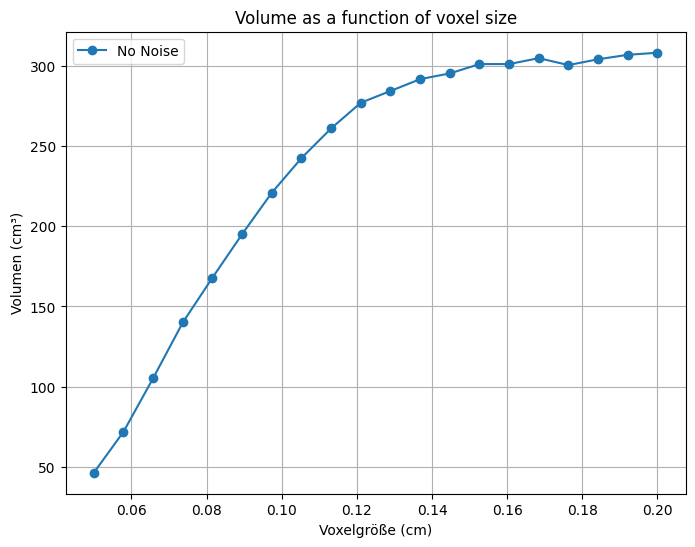

In [244]:
#inspiriet von FoRConvD: An approach for food recognition on  mobile devices using convolutional neural networks  and depth maps

def compute_volume(point_cloud, voxel_size):
    """Voxelisiert die Punktwolke und berechnet das Volumen."""
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size=voxel_size)
    voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3) * 1_000_000  # Volumen in cm³
    return voxel_volumen

def test_voxel_sizes(point_cloud, voxel_sizes):
    """Testet verschiedene Voxelgrößen und plottet das Volumen der Punktwolke."""
    volumes = [compute_volume(point_cloud, vs) for vs in voxel_sizes]
    
    plt.figure(figsize=(8, 6))
    plt.plot(voxel_sizes * 100, volumes, marker='o', linestyle='-', label="No Noise")
    plt.xlabel("Voxelgröße (cm)")
    plt.ylabel("Volumen (cm³)")
    plt.title("Volume as a function of voxel size")
    plt.legend()
    plt.grid(True)
    plt.show()

# Beispiel: Punktwolke laden
voxel_sizes = np.linspace(0.0005, 0.002, 20)  # Voxelgrößen von 0.5 mm bis 2 mm

test_voxel_sizes(pcd_object_comp, voxel_sizes)

In [153]:
print(f"Anzahl der Punkte in der Punktwolke: {len(pcd_object_comp.points)}")


Anzahl der Punkte in der Punktwolke: 839805
